# Importing and calling data files


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os,sys
import fit_schechter as fs
#import reionizer
import glob
import astropy
import astropy.cosmology
import scipy
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate
from scipy.optimize import minimize


plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'



In [198]:
def insensitive_glob(pattern):
    """
    Case insensitive find file names
    """
    def either(c):
        return '[%s%s]'%(c.lower(),c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either,pattern)))

#Call UV LF data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval

#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

#Calling Konno data file
K_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
K_dir = pW_data_dir+'Lya_LF_Konno/' 
K_files = sorted(insensitive_glob(K_dir+'Lya_LF_Konno_z*.txt')) 

#Calling Ouchi data file
O_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
O_dir = pW_data_dir+'Lya_LF_Ouchi/' 
O_files = sorted(insensitive_glob(O_dir+'Lya_LF_Ouchi_z*.txt')) 

#Calling Luminosity Density info
LD_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
LD_dir = pW_data_dir+'LD/' 
LD_files = sorted(insensitive_glob(LD_dir+'LD_info.txt')) 



# Methodology
## Defining function to call files and plotting functions


In [235]:
#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df



#Call UV LF files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 


#Call xHI, EW files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 

#Call Konno z value files
Konno_tab = np.array([float(f.split('z')[-1].split('.txt')[0]) for f in K_files])

#Call Ouchi z value files
Ouchi_tab = np.array([float(f.split('z')[-1].split('.txt')[0]) for f in O_files])




#Call EW file with xHI = 0.01 
#global pW_tab
pW_tab = load_uvf_pandas(pW_files[0]) 

#Get Muv values from EW file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])



[-23.  -22.9 -22.8 -22.7 -22.6 -22.5 -22.4 -22.3 -22.2 -22.1 -22.  -21.9
 -21.8 -21.7 -21.6 -21.5 -21.4 -21.3 -21.2 -21.1 -21.  -20.9 -20.8 -20.7
 -20.6 -20.5 -20.4 -20.3 -20.2 -20.1 -20.  -19.9 -19.8 -19.7 -19.6 -19.5
 -19.4 -19.3 -19.2 -19.1 -19.  -18.9 -18.8 -18.7 -18.6 -18.5 -18.4 -18.3
 -18.2 -18.1 -18.  -17.9 -17.8 -17.7 -17.6 -17.5 -17.4 -17.3 -17.2 -17.1
 -17. ]


In [123]:
#Plot UV LF values vs interpolated Muv that is the same as EW 
def plot_UV_LF(Muv_EW,new_ndens):
    '''
    Plots UV LF for a interpolated EW Muv grid
    
    '''
    plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval_test) #UV LF values (181 Muv vals)
    plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
    #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
    plt.legend()
    plt.xlabel('$M_\mathrm{UV}$')
    plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
    plt.show()
    return

In [6]:
def plot_jvsMuv(jacobian, Muv_EW, zval_test):
    '''
    Plots relationship between lya/EW jacobian vs Muv values
    
    '''
#Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
#As Muv becomes fainter, value for jacobian increases, they're inversely proportional?

    plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval_test)     
    plt.legend()
    plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
    plt.ylabel('$M_\mathrm{UV}$')
    plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
    return


In [7]:
def konno_data_plt(zval_test, plot = False):
    '''
    Plots observational Lya LF data from Konno+18,+14 to fit model
    
    '''
    K_file = sorted(insensitive_glob(K_dir+f'Lya_LF_Konno_z*{zval_test}.txt'))[0]
    Ko_tab = load_uvf_pandas(K_file)
    
   
    yerr_l = 10**(Ko_tab['log(ndens)']) - 10**(Ko_tab['ndens_l2']) 
    yerr_u = 10**(Ko_tab['ndens_u2']) - 10**(Ko_tab['log(ndens)'])
    yerror = np.array([yerr_l,yerr_u])
    
    Ko_ndens = np.array(10**(Ko_tab['log(ndens)']))
    Ko_L = np.array(Ko_tab['log(L)'])
    yerror_mean = np.mean(yerror,axis=0)
    

    if plot==True:
        if zval_test == 5.7:
            my_color = 'blue'
            label2 = 'Konno+18'
        elif zval_test == 6.6:
            my_color = 'red'
            label2 = 'Konno+18'
        else:
            my_color = 'orange'
            label2 = 'Konno+14'



        plt.semilogy(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),color=my_color, alpha=0.5, marker='o', lw=0)
        plt.errorbar(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),yerr=yerror, fmt = ' ',capsize=5, color=my_color)
    return Ko_L, Ko_ndens, yerror_mean

In [8]:
def ouchi_data_plt(zval_test, plot = False):
    '''
    Plots observational Lya LF data from Ouchi+08,+10 to fit model
    
    '''
    O_file = sorted(insensitive_glob(O_dir+f'Lya_LF_Ouchi_z*{zval_test}.txt'))[0]
    Ou_tab = load_uvf_pandas(O_file)
    
   
    yerr_l2 = 10**(Ou_tab['log(ndens)']) - 10**(Ou_tab['ndens_l2']) 
    yerr_u2 = 10**(Ou_tab['ndens_u2']) - 10**(Ou_tab['log(ndens)'])
    yerror2 = np.array([yerr_l2,yerr_u2])
    
    Ou_ndens = np.array(10**(Ou_tab['log(ndens)']))
    Ou_L = np.array(Ou_tab['log(L)'])
    yerror_mean2 = np.mean(yerror2,axis=0)
    

    if plot==True:
        if zval_test == 5.7:
            my_color = 'blue'
            label2 = 'Ouchi+08'
        elif zval_test == 6.6:
            my_color = 'red'
            label2 = 'Ouchi+10'



        plt.semilogy(Ou_tab['log(L)'], 10**(Ou_tab['log(ndens)']),color=my_color, alpha=0.5, marker='^', lw=0)
        plt.errorbar(Ou_tab['log(L)'], 10**(Ou_tab['log(ndens)']),yerr=yerror2, fmt = ' ',capsize=5, color=my_color)
    return Ou_L, Ou_ndens, yerror_mean2



In [9]:
def log10_LF_plot(log10_LF,zval_test,xHI_test,plot = False):
    '''
    This is used to plot the model of the Lya LF at different xHI and z values
    '''
#     plt.semilogy(log10_lg, log10_LF,label = '$\overline{x}_\mathrm{HI}$ = %.2f'%xHI_test)
    plt.semilogy(log10_lg, log10_LF,label = 'z = %.2f'%zval_test)

    return    

In [10]:
def LvsPLya(Muv_array, zval_test, lum_lya, norm_pLya, new_pLya):
    '''
    Still needs to be fixed, new plot created with old code formatting!
    
    Plots relationship between Lum. and P(Lum.) for different Muv and xHI values
    '''
    
    for mm,Muv in enumerate (Muv_array):
            if mm == 0: #first item in Muv_array, i.e. -18.0
                ls = 'solid'
                label = 'z = %.1f'%zval_test
            elif mm == 1: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                ls = 'dashed'
                label = None
            elif mm == 2: # Third item in Muv_array, i.e. -16.0
                ls = 'dashdot'
                plt.loglog(lum_lya[:,mm], norm_pLya[:,mm], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
                plt.plot(lum_grid, new_pLya[:,mm], ls=ls, color = 'blue')

    leg_zval = plt.legend(frameon=False, handletextpad=0.5)
    plt.gca().add_artist(leg_zval)
    #This is the legend for Muv values, -18.0 is solid, -22.0 is dashed, -16.0 is dash-dot
    line2 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
    line3 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
    line1 = mlines.Line2D([], [], color='k', ls='dashdot', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[2])
    plt.legend(handles=[line1, line2, line3], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

    plt.ylim(1e-50,1e-44)
    plt.xlabel(r'${\mathrm{L_\alpha}}$, [$erg/s$]')
    plt.ylabel(r'${ P (L_\alpha \;|\; M_\mathrm{UV})}$')
    return

## Defining constants and evaluating equations for given z value. Defining necessary functions for Lya LF

In [158]:
#Constants and constraints
# xHI_array = np.array([0.29]) #chosen xHI value
# # zval_test = np.array([5.9]) #chosen redshifts
# Konno_zval = np.array([5.7,6.6,7.3])
Muv_array = np.array([-22.0,-16.0]) #chosen Muv to test lum_lya vs Muv similar to EW vs Muv


beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-20 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light
lum_grid = np.logspace(38,44, num = 200) #shape = (50,)
log10_lg = np.log10(lum_grid) #log10 luminosity grid in order to plot it on log10 scale similar to past works


In [23]:
print(Muv_grid)
np.where((Muv_grid==-22.))[0][0]

[-24.  -23.9 -23.8 -23.7 -23.6 -23.5 -23.4 -23.3 -23.2 -23.1 -23.  -22.9
 -22.8 -22.7 -22.6 -22.5 -22.4 -22.3 -22.2 -22.1 -22.  -21.9 -21.8 -21.7
 -21.6 -21.5 -21.4 -21.3 -21.2 -21.1 -21.  -20.9 -20.8 -20.7 -20.6 -20.5
 -20.4 -20.3 -20.2 -20.1 -20.  -19.9 -19.8 -19.7 -19.6 -19.5 -19.4 -19.3
 -19.2 -19.1 -19.  -18.9 -18.8 -18.7 -18.6 -18.5 -18.4 -18.3 -18.2 -18.1
 -18.  -17.9 -17.8 -17.7 -17.6 -17.5 -17.4 -17.3 -17.2 -17.1 -17.  -16.9
 -16.8 -16.7 -16.6 -16.5 -16.4 -16.3 -16.2 -16.1 -16.  -15.9 -15.8 -15.7
 -15.6 -15.5 -15.4 -15.3 -15.2 -15.1 -15.  -14.9 -14.8 -14.7 -14.6 -14.5
 -14.4 -14.3 -14.2 -14.1 -14.  -13.9 -13.8 -13.7 -13.6 -13.5 -13.4 -13.3
 -13.2 -13.1 -13.  -12.9 -12.8 -12.7 -12.6 -12.5 -12.4 -12.3 -12.2 -12.1]


20

In [13]:
Muv_grid = np.round(np.arange(-24, -12, 0.1),1)

#Defines function for lya Luminosity probability
def make_pL_Lya(zval_test, xHI_test):
    
    #Calling UV, EW, Konno files to obtain z and xHI values
    pW_file = sorted(insensitive_glob(pW_dir+f'ln_pWobs_*{xHI_test:.2f}.txt'))[0]
    
    
    #Load in xHI value file
    pW_tab = load_uvf_pandas(pW_file)
    
    #Get Muv values from file as an array to use
    Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
    
    #Defines luminosity distance
    d_l = P15.luminosity_distance(zval_test) 
    
    #Define apparent magnitude equation
    def muv(Muv,d_l,zval_test): 
        p1 = Muv
        p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
        ans = p1 + p2
        return ans    
    muv = muv(Muv_grid,d_l,zval_test)
    
    #Flux density of UV continuum at Lya wavelength from Muv for given zvals
    fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
    fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units
    
    #Jacobian - partial EW / partial Lya Luminosity for given zvals 
    jacobian = 1/((4*np.pi*d_l**2.)*fd_units)
    
    # Flux_Lya
    f_lya = np.outer(pW_tab['W'],fd_units) * u.Angstrom
    
    #Lya luminosity 
    lum_lya = (f_lya * (4*np.pi*d_l**2.)).to(u.erg/u.s)
    
    #Drops first column of EW values
    new_pW_tab = np.exp(pW_tab.drop('W',axis=1))
    
    #EW values for each Muv in EW file
    pEW_vals = np.array(new_pW_tab) 
    
    # Create p(EW | Muv) on bigger Muv grid, assuming the EW distribution 
    # doesn't evolve with magnitude for very bright or very faint galaxies
    pEW_vals_Muv_grid = np.zeros((pEW_vals.shape[0],len(Muv_grid)))
    
    # Index of brightest Muv_EW galaxy in Muv_grid
    m_index = np.where(Muv_grid == np.min(Muv_EW))[0][0]
    for mm, Muv in enumerate(Muv_grid):
        # For faint galaxies, use p(EW | Muv =-17)
        if Muv > np.max(Muv_EW):
            pEW_vals_Muv_grid[:,mm] = pEW_vals[:,-1]
        # For bright galaxies, use p(EW | Muv =-22)
        elif Muv < np.min(Muv_EW):
            pEW_vals_Muv_grid[:,mm] = pEW_vals[:,0]
        # Otherwise use the model p(EW | Muv)
        else:
            pEW_vals_Muv_grid[:,mm] = pEW_vals[:,mm-m_index]
    
    
    # P(Lya|Muv)
    pLya = jacobian * pEW_vals_Muv_grid
    
    #Normalizes pLya to correctly plot lum_lya vs pLya
    A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
    integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
    sum_int = A1 + integral #This is whole integral of p(L)dL
    norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize
    new_A1 = norm_pLya[0]
    integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
    new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
    assert(new_sum.value.all() == 1.)
    
    
    #Define an empty matrix in order to fill later with luminosity grid values and Muv values
    new_pLya = np.zeros((len(lum_grid), len(Muv_grid))) 
    
    for mm,Muv in enumerate (Muv_grid):
        #Interpolating pLya and ndens values into a 1d array
        LF_interp1 = interpolate.interp1d(lum_lya[:,mm],norm_pLya[:,mm],fill_value=0., bounds_error=False)
        new_pLya[:,mm] = LF_interp1(lum_grid) #column values of pLya
    
    return Muv_grid, new_pLya


Text(0, 0.5, '$<\\mathrm{L_\\alpha}>$ [erg/s]')

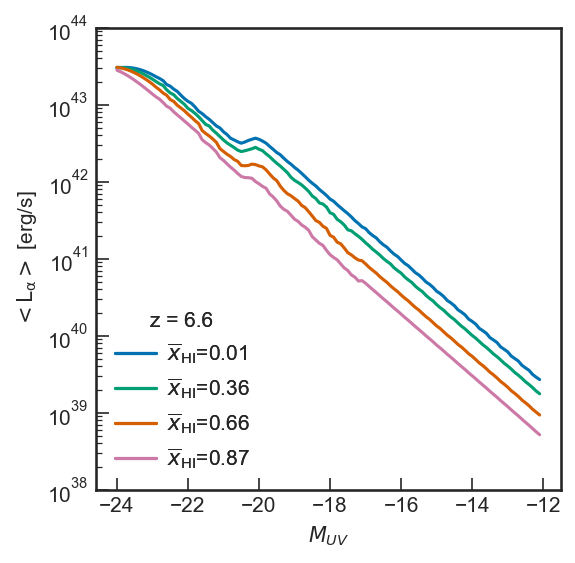

In [14]:
#Plot Muv vs expectation value of lya luminosity
plt.figure(figsize=(4.,4.), dpi=150)
Muv_grid, new_pLya = make_pL_Lya(zval_test=6.6, xHI_test=0.01)
expec_L = np.trapz((lum_grid*(new_pLya.T)),x=lum_grid)
plt.semilogy(Muv_grid,expec_L,label='$\overline{x}_\mathrm{HI}$=0.01')

Muv_grid, new_pLya = make_pL_Lya(zval_test=6.6, xHI_test=0.36)
expec_L = np.trapz((lum_grid*(new_pLya.T)),x=lum_grid)
plt.semilogy(Muv_grid,expec_L,label='$\overline{x}_\mathrm{HI}$=0.36')

Muv_grid, new_pLya = make_pL_Lya(zval_test=6.6, xHI_test=0.66)
expec_L = np.trapz((lum_grid*(new_pLya.T)),x=lum_grid)
plt.semilogy(Muv_grid,expec_L,label='$\overline{x}_\mathrm{HI}$=0.66')

Muv_grid, new_pLya = make_pL_Lya(zval_test=6.6, xHI_test=0.87)
expec_L = np.trapz((lum_grid*(new_pLya.T)),x=lum_grid)
plt.semilogy(Muv_grid,expec_L,label='$\overline{x}_\mathrm{HI}$=0.87')

#Legends,axes info
leg_zval1 = plt.legend(title ='z = 6.6',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval1)
plt.ylim(1e38,1e44)
plt.xlabel(r'$M_{UV}$')
plt.ylabel(r'$<\mathrm{L_\alpha}>$ [erg/s]')
# plt.savefig('ExpectationLya.pdf', bbox_inches='tight')
# plt.show()


Text(0, 0.5, 'Lum. distance')

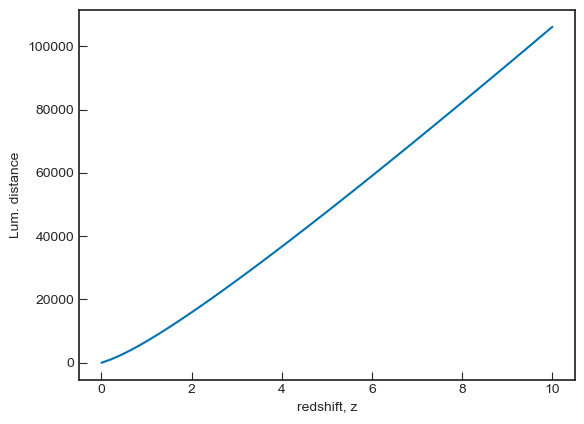

In [15]:
# Test - Relationship between redshift and lum. distance 
zval_tests=np.linspace(0,10)
d_l = P15.luminosity_distance(zval_tests)
plt.plot(zval_tests,d_l)
plt.xlabel('redshift, z')
plt.ylabel('Lum. distance')

In [76]:
#Defining lya LF function and all necessary eqs needed 

def make_lya_LF(zval_test, xHI_test, F=1., plot=False, log=True):
    #Calling UV, EW, Konno files to obtain z and xHI values
    LFz_file = sorted(insensitive_glob(LFz_dir+ f'LF_pred_z{zval_test}.txt'))[0] 
    
    # Make p(L_Lya | Muv)
    Muv_grid, new_pLya = make_pL_Lya(zval_test, xHI_test)
    
    #Load in z value file
    LF_tab = load_uvf_pandas(LFz_file) 
    
    
    #Interpolating UV LF Muv and ndens values into a 1d array
    LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
    new_ndens = LF_interp(Muv_grid)

        
    #Product of UVLF ndens values * pLya in new luminosity grid
    product_LF = new_ndens * new_pLya 


    #Integral of this product = Lya LF (missing fudge factor corrections)
    lya_LF =np.trapz(product_LF, x = Muv_grid) 


    #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
    log10_LF = lya_LF*np.log(10)*lum_grid
    
    
        
    
    ## CALLING FUNCTIONS 
    
    #Plotting Information
    if plot == True:
        #Plot Konno info 
#         konno_data_plt(zval_test, plot = True)
        
        #Plot Ouchi info
#         ouchi_data_plt(zval_test, plot = True)

#         #Jacobian vs Muv plot info
#         plot_jvsMuv(jacobian, Muv_EW, zval_test)

#         #Plot Lum vs PLum info
#         LvsPLya(Muv_array, zval_test, lum_lya, norm_pLya, new_pLya)

        #LF vs Konno plot info
        log10_LF_plot(log10_LF,zval_test,xHI_test, plot = True)
        

    
    if log == True:
        return F*log10_LF
    else:
        return F*lya_LF

Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

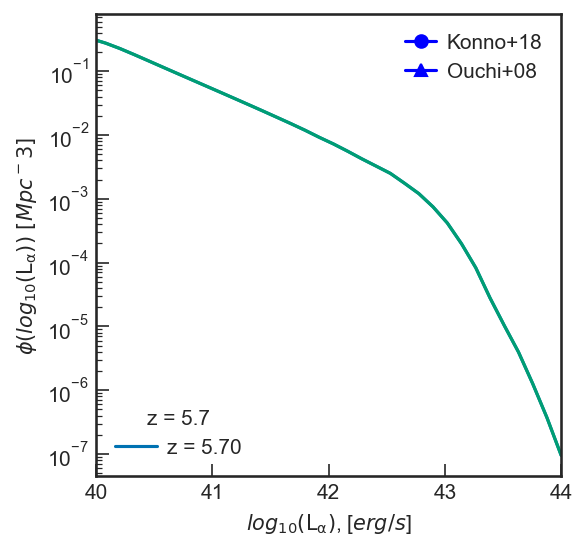

In [31]:
#Calibrated Lya LF

plt.figure(figsize=(4.,4.), dpi=150)
log10_LF_calibrate = make_lya_LF(zval_test = 5.7,xHI_test = 0.01, F = 1., plot=True)
plt.semilogy(log10_lg, log10_LF_calibrate)

leg_zval1 = plt.legend(title = 'z = 5.7',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval1)
line2 = mlines.Line2D([], [], color='blue', marker='o', label='Konno+18')
line3 = mlines.Line2D([], [], color='blue', marker='^', label='Ouchi+08')
plt.legend(handles=[line2,line3], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.xlim(40,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('CalibratedKonnovsLF.pdf', bbox_inches='tight')
# plt.show()

In [32]:
def line_model(F, Ko_L):
    """
    Evaluate a straight line model at the input Konno luminosity values.
    
    Parameters
    ----------
    F : list, array
        This should be a length-2 array or list containing the 
        parameter values (a, b) for the (slope, intercept).
    new_phi_Li : numeric, list, array
        The coordinate values.
        
    Returns
    -------
    F*new_phi_Li : array
        The computed y values at each input x.
    """
    #Interpolating Konno and lum grid 
    LF_interp2 = interpolate.interp1d(log10_lg, log10_LF_calibrate)
    new_phi_Li = LF_interp2(Ko_L)
    
    return F*new_phi_Li

def line_model2(F, Ou_L):
    """
    Evaluate a straight line model at the input Ouchi luminosity values.
    
    Parameters
    ----------
    F : list, array
        This should be a length-2 array or list containing the 
        parameter values (a, b) for the (slope, intercept).
    new_phi_Li : numeric, list, array
        The coordinate values.
        
    Returns
    -------
    F*new_phi_Li2 : array
        The computed y values at each input x.
    """
    #Interpolating Ouchi and lum grid 
    LF_interp3 = interpolate.interp1d(log10_lg, log10_LF_calibrate)
    new_phi_Li2 = LF_interp3(Ou_L)
    
    return F*new_phi_Li2

F = np.linspace(0,2) #Start prediction F to be within 0-2 range

def weighted_squared_deviation(F):
    """
    Chi = Konno, Ouchi ndens values - our ndens values at corresponding Konno lum grid * F / Konno error values
    Compute the weighted squared deviation between the data 
    (x, y, y_err) and the model points computed with the input 
    parameters (F).
    """
    Ko_L, Ko_ndens, yerror_mean = konno_data_plt(zval_test=5.7, plot = False) #Defined here rather than as func. parameters
    chi_Ko = (Ko_ndens - line_model(F[:,None], Ko_L)) / yerror_mean
    
    Ou_L, Ou_ndens, yerror_mean2 = ouchi_data_plt(zval_test=5.7, plot = False) #Defined here rather than as func. parameters
    chi_Ou = (Ou_ndens - line_model2(F[:,None], Ou_L)) / yerror_mean2
    
 
    return np.sum(chi_Ko**2, axis=1) + np.sum(chi_Ou**2, axis=1)
# plt.plot(F, weighted_squared_deviation(F)) #Plot to estimate min. F value


x0 = 0.6 # starting guess for the optimizer 
result_sq = minimize(weighted_squared_deviation, x0=x0,method='BFGS')
best_pars_sq = result_sq.x
print(best_pars_sq)

[0.59836728]


# Lya LF Plots (z = 5.7, 6.6, 7.3)

Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

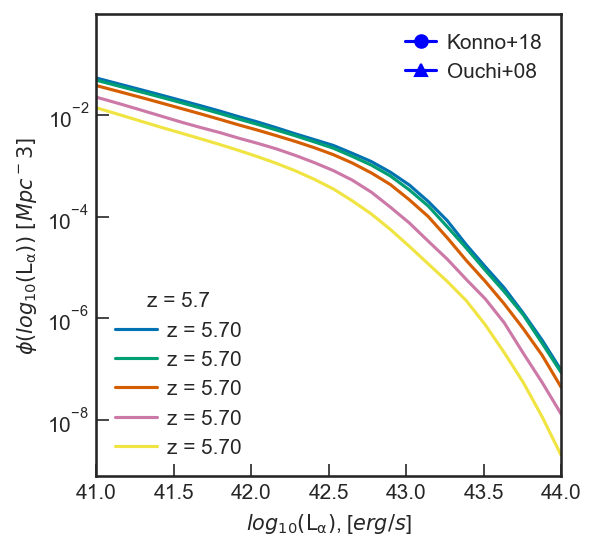

In [33]:
#LF z = 5.7
#Uses Konno and Ouchi functions

plt.figure(figsize=(4.,4.), dpi=150)
log10_LF1 = make_lya_LF(zval_test = 5.7,xHI_test = 0.01,F=0.598, plot=True)
log10_LF2 = make_lya_LF(zval_test = 5.7,xHI_test = 0.15,F=0.598,plot=True)
log10_LF3 = make_lya_LF(zval_test = 5.7,xHI_test = 0.36, F=0.598, plot=True)
log10_LF4 = make_lya_LF(zval_test = 5.7,xHI_test = 0.66,F=0.598, plot=True)
log10_LF5 = make_lya_LF(zval_test = 5.7,xHI_test = 0.87,F=0.598, plot=True)

leg_zval1 = plt.legend(title = 'z = 5.7',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval1)
line2 = mlines.Line2D([], [], color='blue', marker='o', label='Konno+18')
line3 = mlines.Line2D([], [], color='blue', marker='^', label='Ouchi+08')
plt.legend(handles=[line2,line3], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.xlim(41,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('KonnovsLF5.7.pdf', bbox_inches='tight')
# plt.show()


Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

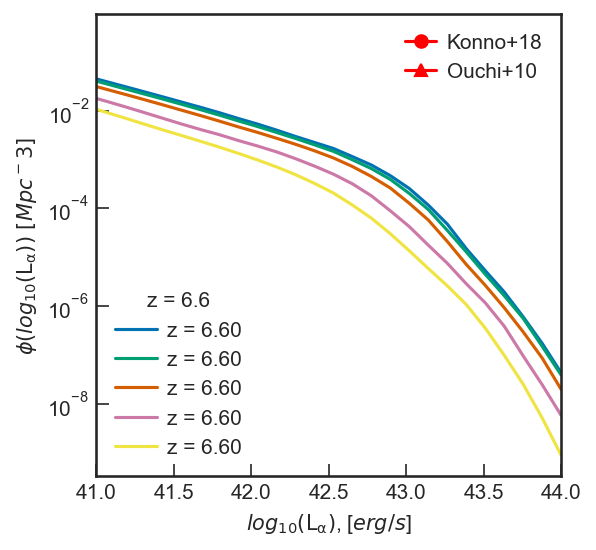

In [34]:
#LF z = 6.6
#Uses Konno and Ouchi functions

plt.figure(figsize=(4.,4.), dpi=150)
log10_LF6 = make_lya_LF(zval_test = 6.6,xHI_test = 0.01, F=0.598, plot=True)
log10_LF7 = make_lya_LF(zval_test = 6.6,xHI_test = 0.15,F=0.598,plot=True)
log10_LF8 = make_lya_LF(zval_test = 6.6,xHI_test = 0.36, F=0.598, plot=True)
log10_LF9 = make_lya_LF(zval_test = 6.6,xHI_test = 0.66, F=0.598, plot=True)
log10_LF10 = make_lya_LF(zval_test = 6.6,xHI_test = 0.87, F=0.598, plot=True)


leg_zval2 = plt.legend(title = 'z = 6.6',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval2)
line2 = mlines.Line2D([], [], color='red', marker='o', label='Konno+18')
line3 = mlines.Line2D([], [], color='red', marker='^', label='Ouchi+10')
plt.legend(handles=[line2,line3], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.xlim(41,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('KonnovsLF6.6.pdf', bbox_inches='tight')
# plt.show()

Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

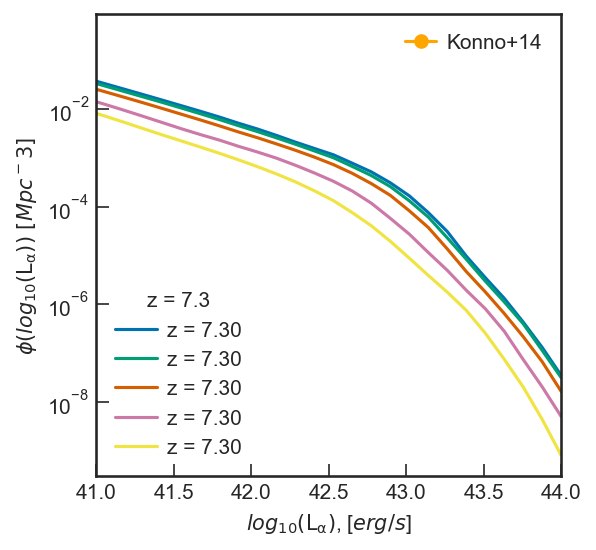

In [35]:
# #LF z = 7.3
# #Uses Konno function (**COMMENT OUT OUCHI FUNCTION**)

plt.figure(figsize=(4.,4.), dpi=150)
log10_LF11 = make_lya_LF(zval_test = 7.3,xHI_test = 0.01, F=0.598, plot=True)
log10_LF12 = make_lya_LF(zval_test = 7.3,xHI_test = 0.15,F=0.598,plot=True)
log10_LF13 = make_lya_LF(zval_test = 7.3,xHI_test = 0.36, F=0.598, plot=True)
log10_LF14 = make_lya_LF(zval_test = 7.3,xHI_test = 0.66, F=0.598, plot=True)
log10_LF15 = make_lya_LF(zval_test = 7.3,xHI_test = 0.87, F=0.598, plot=True)

leg_zval3 = plt.legend(title = 'z = 7.3',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval3)
line2 = mlines.Line2D([], [], color='orange', marker='o', label='Konno+14')
plt.legend(handles=[line2], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.xlim(41,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('KonnovsLF7.3.pdf', bbox_inches='tight')
# plt.show()

Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

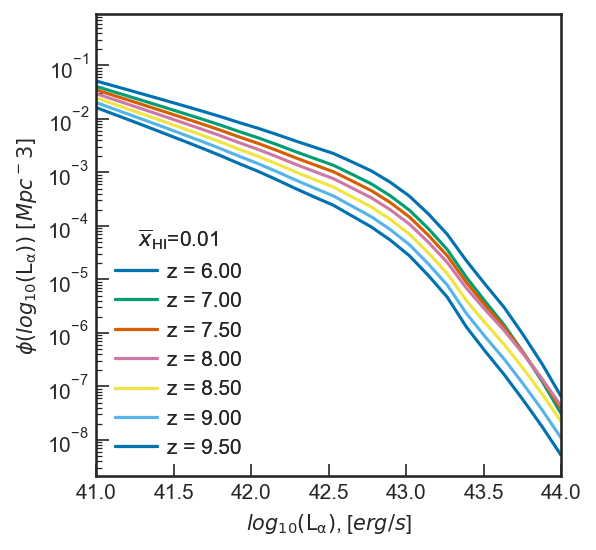

In [36]:
# #LF z = 7,8,8.5,9,9.5

plt.figure(figsize=(4.,4.), dpi=150)
log10_LFc = make_lya_LF(zval_test = 6.0,xHI_test = 0.01, F=0.598, plot=True)
log10_LF11 = make_lya_LF(zval_test = 7.0,xHI_test = 0.01, F=0.598, plot=True)
log10_LF16 = make_lya_LF(zval_test = 7.5,xHI_test = 0.01, F=0.598, plot=True)
log10_LF12 = make_lya_LF(zval_test = 8.0,xHI_test = 0.01,F=0.598,plot=True)
log10_LF13 = make_lya_LF(zval_test = 8.5,xHI_test = 0.01, F=0.598, plot=True)
log10_LF14 = make_lya_LF(zval_test = 9.0,xHI_test = 0.01, F=0.598, plot=True)
log10_LF15 = make_lya_LF(zval_test = 9.5,xHI_test = 0.01, F=0.598, plot=True)

leg_zval3 = plt.legend(title = '$\overline{x}_\mathrm{HI}$=0.01',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval3)
# line2 = mlines.Line2D([], [], color='orange', marker='o', label='Konno+14')
# plt.legend(handles=[line2], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.xlim(41,44)
plt.xlabel(r'$log_{10}(\mathrm{L_\alpha})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.savefig('KonnovsLF7.3.pdf', bbox_inches='tight')
# plt.show()

# Fitting Schechter parameters to LF

100%|██████████| 1000/1000 [00:09<00:00, 107.84it/s]


array([-2.02001737, 43.14138315, -3.87785547])

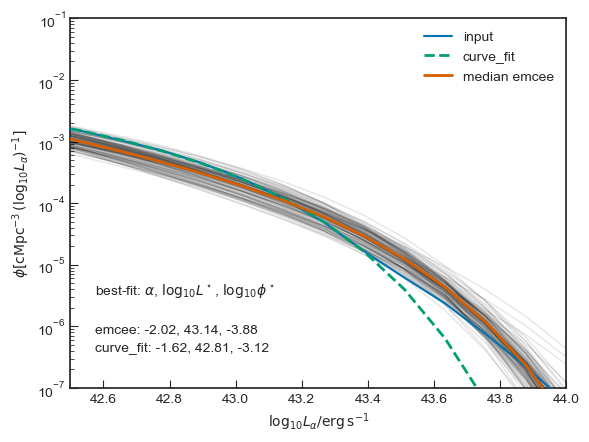

In [37]:
def schechter_fit(zval_test, xHI_test, plot=False):
    #Call LF function
    log10_LF = make_lya_LF(zval_test, xHI_test, F=0.598, plot=False)
    
    #Emcee Information
    # Run emcee to get posterior samples
    sampler = fs.fit_schechter_emcee(log10_lg, log10_LF, logL_min=41., logL_max=44.)
    
    if plot==True:
        plt.figure()
        fs.plot_emcee_draws(sampler, log10_lg, log10_LF, xlim=(42.5, 44))
#         plt.savefig('emceeDrawsFit.pdf', bbox_inches='tight')
#         plt.show()
    medians = fs.get_emcee_medians(sampler)
    return medians
schechter_fit(zval_test=5.7, xHI_test=0.01, plot=True)






[-2.91439824 43.35213711 -4.53667684] [0.1603683  0.05660449 0.20016962]


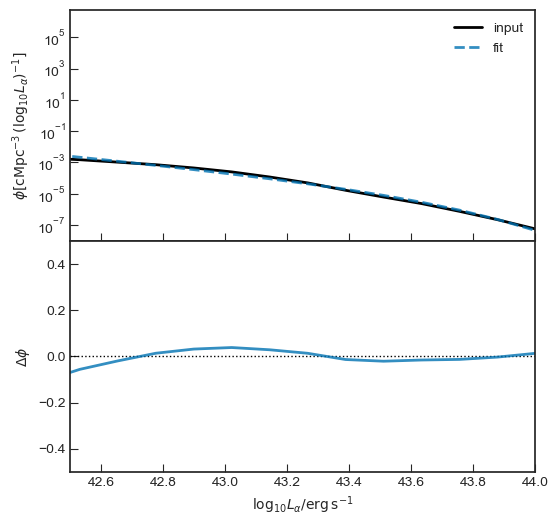

In [38]:
#Call LF function
log10_LF = make_lya_LF(zval_test=5.7, xHI_test=0.01, F=0.598, plot=False)


#Schechter Information
# find the fitted params and their errors
p_scipy, err = fs.fit_schechter_scipy(log10_lg, log10_LF, logL_min=42.5, logL_max=44.)
print(p_scipy, err)

# Plot
fig, ax = plt.subplots(2,1, figsize=(6, 6), sharex=True)

# Plot the input LF
ax[0].semilogy(log10_lg, log10_LF, c='k', lw=2, label='input')

# Plot the model LF
ax[0].plot(log10_lg, fs.schechter_logL(log10_lg, *p_scipy), ls='dashed', lw=2, alpha=0.8, label='fit')

# Plot the fractional difference between the model and the data
ax[1].axhline(0, lw=1, ls='dotted', c='k')
ax[1].plot(log10_lg, (fs.ln_schechter_logL(log10_lg, *p_scipy)-np.log(log10_LF))/np.log(log10_LF), lw=2, alpha=0.8)


ax[0].legend()

ax[1].set_xlabel(r'$\log_{10} L_\alpha/{\mathrm{erg \, s}^{-1}}$')
ax[0].set_ylabel(r'$\phi[\mathrm{cMpc}^{-3}\, (\log_{10} L_\alpha)^{-1}]$')
ax[1].set_ylabel(r'$\Delta \phi$')
ax[1].set_ylim(-0.5,0.5)
ax[1].set_xlim(42.5,44)

fig.subplots_adjust(hspace=0)
plt.savefig('scipyCurveFit.pdf', bbox_inches='tight')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:08<00:00, 119.22it/s]


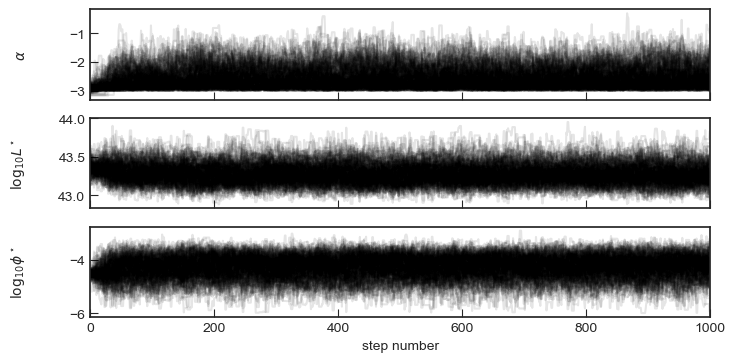

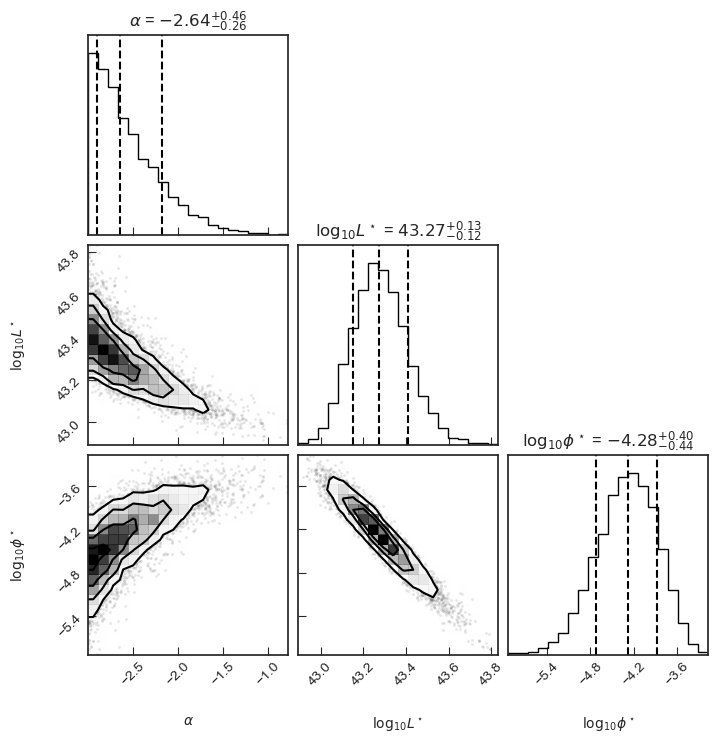

-2.64	0.26	0.46	43.27	0.12	0.13	-4.28	0.44	0.40
[-2.64194057 43.27431759 -4.27536881]


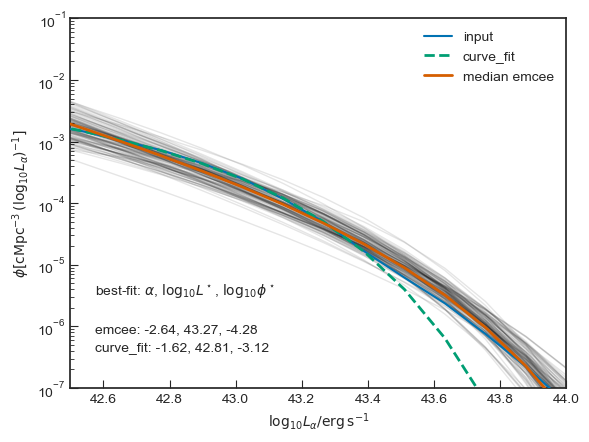

In [39]:
#Emcee Information
# Run emcee to get posterior samples
sampler = fs.fit_schechter_emcee(log10_lg, log10_LF, logL_min=42.5, logL_max=44.)
# Plot posterior chains and corner plot
fs.plot_emcee(sampler)
plt.savefig('emceeFit.pdf', bbox_inches='tight')
plt.show()


plt.figure()
fs.plot_emcee_draws(sampler, log10_lg, log10_LF, xlim=(42.5, 44))
# plt.savefig('emceeDrawsFit.pdf', bbox_inches='tight')
# plt.show()
print(fs.get_emcee_params(sampler))
medians = fs.get_emcee_medians(sampler)
print(medians)

In [27]:
Schechter_params = {} #Schecter param. dictionary
zval_test = LFz_tab
xHI_test = xHI_tab
print(zval_test)
print(xHI_test)
for zval in zval_test:
    for xHI in xHI_test:
        medians = schechter_fit(zval_test=zval, xHI_test=xHI, plot=True)
        Schechter_params[(zval,xHI)] = medians 
Schechter_params

[10.   5.   5.5  5.7  6.   6.5  6.6  6.8  7.   7.3  7.5  7.9  8.   8.5
  9.   9.5]
[0.01 0.02 0.05 0.07 0.09 0.12 0.15 0.18 0.22 0.25 0.29 0.32 0.36 0.39
 0.42 0.45 0.49 0.52 0.55 0.58 0.61 0.64 0.66 0.69 0.72 0.74 0.76 0.78
 0.8  0.82 0.84 0.86 0.87 0.89 0.9  0.91 0.92 0.93 0.94 0.95]


NameError: name 'schechter_fit' is not defined

In [40]:
np.save('Schechter_params.npy',Schechter_params)
np.load('Schechter_params.npy',allow_pickle=True)

array({}, dtype=object)

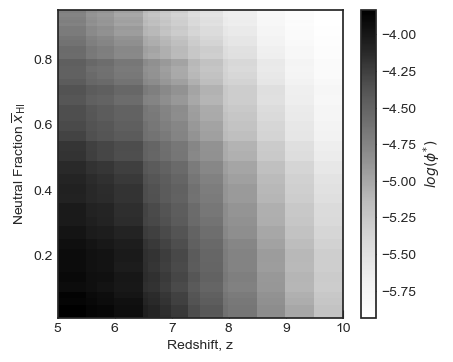

/Applications/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=24,32 m=640 fp=0.138972 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


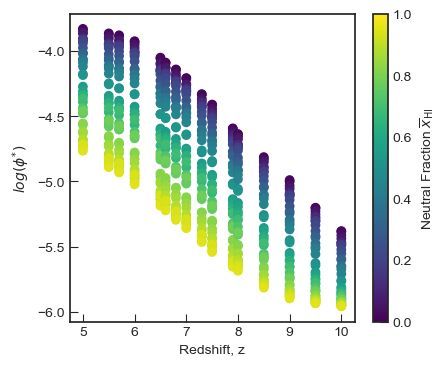

In [446]:
import itertools as it
def dict_to_2Dplot(p_dict, p_index=0, p_name=r'$log(\phi^{*})$', cmap='viridis'):
    """
    Input a dictionary with keys (z, xHI) with values p = (alpha, logLstar, logPhistar)
    Plot p(z, xHI) and xHI(z, p) -- requires interpolating.
    """
    keys    = np.array([[k[0], k[1]] for k in p_dict.keys()])
    z_all   = keys[:,0]
    xHI_all = keys[:,1]
    
    # find unique z and xHI values
    z_array   = np.unique(z_all)    
    xHI_array = np.unique(xHI_all)
    
    # Get all the values of the parameter (at index) from the dictionary
    p_values = np.array([v for v in p_dict.values()])[:,p_index]
    
    # Create a grid of the parameter values
    p_array   = np.linspace(p_values.min(), p_values.max(), 100)   
    
    # -------------------------
    # Fill the 2D array of parameter values from the dictionary and plot
    p_image = np.zeros((len(z_array),len(xHI_array)))
    
    for (i,z), (j,xHI) in it.product(enumerate(z_array), enumerate(xHI_array)):
        p_image[i, j] = p_dict[(z,xHI)][p_index]        
    
    plt.figure(figsize=(4.6,4))
    plt.pcolormesh(z_array, xHI_array, p_image.T)
    plt.colorbar(label=p_name)
    plt.xlabel('Redshift, z')
#     plt.ylabel('Neutral Fraction $\overline{x}_\mathrm{HI}$')
#     plt.savefig('Schechter_zxHIPhistar.pdf', bbox_inches='tight')
#     plt.show()
    # -------------------------
    # We have parameter(z, xHI), want to get xHI(z, p) so we need to interpolate
    # from our current list of all z values, all p values and all xHI values to
    # to the grids we want to plot on
    xHI_interp = scipy.interpolate.interp2d(z_all, p_values, xHI_all, 
                                            kind='linear', fill_value=np.nan)
    
    # interpolate onto the correct z and p grid
    new_xHI = xHI_interp(z_array, p_array)
    
    # correct interpolated values which go to xHI=0 when they shouldn't be
    new_xHI[new_xHI == 0.] = np.nan
    
    plt.figure(figsize=(4.6,4))
    plt.scatter(z_all, p_values, c=xHI_all, cmap=cmap, vmin=0, vmax=1.)
    plt.colorbar(label='Neutral Fraction $\overline{x}_\mathrm{HI}$')
    plt.xlabel('Redshift, z')
    plt.ylabel(p_name) 
#     plt.savefig('Schechter_zPhistar.pdf', bbox_inches='tight')
#     plt.show()
    return
dict_to_2Dplot(p_dict=Schechter_params, p_index=2)

# Luminosity density given luminosity, number density

In [258]:
#Call LD columns
LD_tab = load_uvf_pandas(LD_files[0])



LDyerr_l = LD_tab['log(LD)'] - LD_tab['err_l']
LDyerr_u = LD_tab['err_u'] - LD_tab['log(LD)']
LDyerror = np.array([LDyerr_l,LDyerr_u])
LDyerror_mean = np.mean(LDyerror,axis=0)



[['Konno+18'], ['Konno+18'], ['Zheng+17'], ['Zheng+17'], ['Konno+14']]


In [178]:
def LD_info(zval_test,xHI_test):
    lum_lower = 10**42.4 #lower limit of luminosity grid
    phiL = make_lya_LF(zval_test,xHI_test, F=0.598, plot=False, log=False)
    LD = np.trapz((lum_grid*phiL)[lum_grid >= lum_lower],x=lum_grid[lum_grid >= lum_lower])
    return LD


LD_dict = {} #luminosity density dictionary
zval_test = LFz_tab
xHI_test = xHI_tab
print(zval_test)
print(xHI_test)
for zval in zval_test:
    for xHI in xHI_test:
        LD_plot = LD_info(zval_test=zval,xHI_test=xHI)
        LD_dict[(zval,xHI)] = LD_plot
LD_dict

[10.   5.   5.5  5.7  6.   6.5  6.6  6.8  7.   7.3  7.5  7.9  8.   8.5
  9.   9.5]
[0.01 0.02 0.05 0.07 0.09 0.12 0.15 0.18 0.22 0.25 0.29 0.32 0.36 0.39
 0.42 0.45 0.49 0.52 0.55 0.58 0.61 0.64 0.66 0.69 0.72 0.74 0.76 0.78
 0.8  0.82 0.84 0.86 0.87 0.89 0.9  0.91 0.92 0.93 0.94 0.95]


{(10.0, 0.01): 1.672011823539399e+38,
 (10.0, 0.02): 1.648777724529519e+38,
 (10.0, 0.05): 1.6132842699892256e+38,
 (10.0, 0.07): 1.5734119659481254e+38,
 (10.0, 0.09): 1.5122771199293712e+38,
 (10.0, 0.12): 1.4705583174949566e+38,
 (10.0, 0.15): 1.3913021047470712e+38,
 (10.0, 0.18): 1.3182607025312754e+38,
 (10.0, 0.22): 1.2517972658842884e+38,
 (10.0, 0.25): 1.1488166239566203e+38,
 (10.0, 0.29): 1.0789229835909369e+38,
 (10.0, 0.32): 9.937598874397446e+37,
 (10.0, 0.36): 9.255435329933138e+37,
 (10.0, 0.39): 8.404054643851179e+37,
 (10.0, 0.42): 7.802079124767527e+37,
 (10.0, 0.45): 7.147691831750982e+37,
 (10.0, 0.49): 6.376641491618657e+37,
 (10.0, 0.52): 5.787612108493373e+37,
 (10.0, 0.55): 5.181426530340042e+37,
 (10.0, 0.58): 4.743215379408323e+37,
 (10.0, 0.61): 4.2027960050594456e+37,
 (10.0, 0.64): 3.8142389931444097e+37,
 (10.0, 0.66): 3.3737538270871006e+37,
 (10.0, 0.69): 3.031727866817981e+37,
 (10.0, 0.72): 2.6680670124789435e+37,
 (10.0, 0.74): 2.3846315502694667e+37

In [179]:
np.save('LD_values.npy',LD_dict)
np.load('LD_values.npy',allow_pickle=True)

array({(10.0, 0.01): 1.672011823539399e+38, (10.0, 0.02): 1.648777724529519e+38, (10.0, 0.05): 1.6132842699892256e+38, (10.0, 0.07): 1.5734119659481254e+38, (10.0, 0.09): 1.5122771199293712e+38, (10.0, 0.12): 1.4705583174949566e+38, (10.0, 0.15): 1.3913021047470712e+38, (10.0, 0.18): 1.3182607025312754e+38, (10.0, 0.22): 1.2517972658842884e+38, (10.0, 0.25): 1.1488166239566203e+38, (10.0, 0.29): 1.0789229835909369e+38, (10.0, 0.32): 9.937598874397446e+37, (10.0, 0.36): 9.255435329933138e+37, (10.0, 0.39): 8.404054643851179e+37, (10.0, 0.42): 7.802079124767527e+37, (10.0, 0.45): 7.147691831750982e+37, (10.0, 0.49): 6.376641491618657e+37, (10.0, 0.52): 5.787612108493373e+37, (10.0, 0.55): 5.181426530340042e+37, (10.0, 0.58): 4.743215379408323e+37, (10.0, 0.61): 4.2027960050594456e+37, (10.0, 0.64): 3.8142389931444097e+37, (10.0, 0.66): 3.3737538270871006e+37, (10.0, 0.69): 3.031727866817981e+37, (10.0, 0.72): 2.6680670124789435e+37, (10.0, 0.74): 2.3846315502694667e+37, (10.0, 0.76): 2.0

/Applications/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=24,32 m=640 fp=0.006675 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


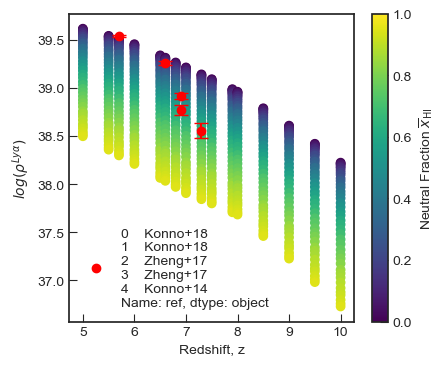

In [255]:
import itertools as it
def dict_to_LDplot(p_dict, p_index=0, p_name=r'$log(\rho^{Ly\alpha})$', cmap='viridis'):
    """
    Input a dictionary with keys (z, xHI) with values p = (alpha, logLstar, logPhistar)
    Plot p(z, xHI) and xHI(z, p) -- requires interpolating.
    """
    
    keys    = np.array([[k[0], k[1]] for k in p_dict.keys()])
    z_all   = keys[:,0]
    xHI_all = keys[:,1]
    
    # find unique z and xHI values
    z_array   = np.unique(z_all)    
    xHI_array = np.unique(xHI_all)
    

    # Get all the values of the parameter (at index) from the dictionary
#     p_values = np.array([v for v in p_dict.values()])[:,p_index]
    p_values = np.array([v for v in p_dict.values()])
    
    # Create a grid of the parameter values
    p_array   = np.linspace(p_values.min(), p_values.max(), 100)   
    

    # We have parameter(z, xHI), want to get xHI(z, p) so we need to interpolate
    # from our current list of all z values, all p values and all xHI values to
    # to the grids we want to plot on
    xHI_interp = scipy.interpolate.interp2d(z_all, p_values, xHI_all, 
                                            kind='linear', fill_value=np.nan)
    
    # interpolate onto the correct z and p grid
    new_xHI = xHI_interp(z_array, p_array)
    
    # correct interpolated values which go to xHI=0 when they shouldn't be
    new_xHI[new_xHI == 0.] = np.nan
    


    
    plt.figure(figsize=(4.6,4))
    plt.plot(LD_tab['z'], LD_tab['log(LD)'], marker = 'o',lw = 0, color = 'red', label = LD_tab['ref'])
    plt.errorbar(LD_tab['z'], LD_tab['log(LD)'],yerr=LDyerror, fmt = ' ',capsize=5, color='red')
    plt.scatter(z_all, np.log10(p_values), c=xHI_all, cmap=cmap, vmin=0, vmax=1.)
    plt.colorbar(label='Neutral Fraction $\overline{x}_\mathrm{HI}$')
    plt.legend()
    plt.xlabel('Redshift, z')
    plt.ylabel(p_name) 
#     plt.savefig('LD.pdf', bbox_inches='tight')
#     plt.show()
    return
dict_to_LDplot(p_dict=LD_dict, p_index=0)

In [196]:
print(np.log10(38.55))
print(10**1.586024)


1.5860243823869757
38.54996605756684
